/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


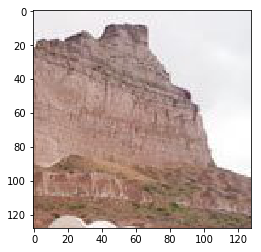

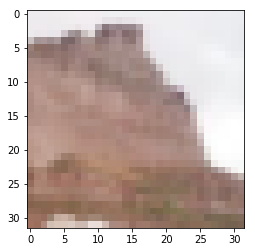

In [36]:
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import model

# LR image size
imageSize = 32
# upSampling from LR image to HR image
upSampling = 4
batchSize = 16
dataroot = './Test_data' # Change to test data

netG = torch.load('SavedNetworks/Generator_best.pt')
netD = torch.load('SavedNetworks/Discriminator_best.pt')

# random crop for HR images with fixed size
transform = transforms.Compose([transforms.RandomCrop(imageSize*upSampling), transforms.ToTensor()])

# normalize the images
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# unnormalize the images
unnormalize = transforms.Normalize(mean = [-2.118, -2.036, -1.804], std = [4.367, 4.464, 4.444])

# produce LR images from HR images
scale = transforms.Compose([transforms.ToPILImage(),
                            transforms.Scale(imageSize),
                            transforms.ToTensor()
                            ])

testset = datasets.ImageFolder(root=dataroot, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=True)

low_res = torch.FloatTensor(batchSize, 3, imageSize, imageSize)

for i, data in enumerate(testloader):
    high_res_real, _ = data

toPIL = transforms.ToPILImage()
img_orig = toPIL(high_res_real.data[-1])
low_res = scale(high_res_real.data[-1])
img_lr = toPIL(low_res)

plt.figure()
plt.imshow(img_orig)
plt.figure()
plt.imshow(img_lr)